In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import astropy
from astropy.table import Table
from heron import data, regression, corner, priors, sampling
import os
import heron
from glob import glob
import numpy as np

In [3]:
# Keep track of the various times that things happen at
ptimes = {}

headers = ['Index', 'Name', 'tag', '$q$', '$a_{1x}$', '$a_{1y}$', '$a_{1z}$', '$a_{2x}$', '$a_{2y}$', '$a_{2z}$', '$L_x$', '$L_y$', '$L_z$', 'mf', 'af', 'mW']
t = Table.read('/home/daniel/data/gravitational-waves/gt-new/GT_CATALOG_TABLE.txt', format="ascii", names=headers)

In [4]:
columns = ['t', '$q$', '$a_{1x}$', '$a_{1y}$', '$a_{1z}$', '$a_{2x}$', '$a_{2y}$', '$a_{2z}$', '$L_z$']

In [5]:
def get_dataset(t, query, waveforms = 40, inspiral = 250, ringdown = 50, skip = 10):
    default_path = "/home/daniel/data/gravitational-waves/gt-old/"

    def find_data(tag, path = default_path):
        """
        Find the data files which contain the NR data for a given tag.
        """
        result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*{}*.asc'.format(tag)))]
        return result

    #
    t = t[query]
    inspiral = -1 * inspiral
    columns = ['t', '$q$', '$a_{1x}$', '$a_{1y}$', '$a_{1z}$', '$a_{2x}$', '$a_{2y}$', '$a_{2z}$', '$L_z$']


    total_waveforms = waveforms

    training_x = []
    training_y = []
    waveformsinc = 0
    waveform_table = []
    for j,row in enumerate(t):
        if waveformsinc >= total_waveforms:  break
        waveform_file = find_data(row['tag'])
        #print waveform_file
        #print waveform_file
        if len(waveform_file)!=1:
            continue
        waveform_table.append(j)
        waveformsinc += 1
        data = np.loadtxt(waveform_file[0])[::skip]

        hrss = np.sqrt(data[:,1]**2 + data[:,2]**2)

        data[:,0] = data[:,0] - data[np.argmax(hrss),0]
        times = data[:,0]#[hrss.argmax()-200:hrss.argmax() + 50]
        if len(times)==0: continue
        
        ix_selection = (times>=inspiral) & (times<=ringdown)
        times = times[ix_selection]
       
        
        rowdata = np.zeros((len(columns), len(times)))
        for i, col in enumerate(columns):
            if i == 0: 
                rowdata[i,:] = data[:,0][ix_selection]
            else:
                rowdata[i,:] = np.tile(row[col], len(times))
        training_y.append(data[:,2][ix_selection])
        training_x.append(np.atleast_2d(rowdata))
    training_y = np.hstack(training_y)
    training_x = np.hstack(training_x)
    return training_x, training_y

In [6]:
from george import kernels

In [7]:
import george

In [8]:
import scipy.optimize

In [9]:
def neglk(x, gp, training):
    if np.any(x<0): return np.inf
    x = np.log(x)
    if not np.all(np.isfinite(x)): return np.inf
    gp.set_parameter_vector(x)
    return -gp.log_likelihood(training.labels, quiet=True)#,# -gp.grad_log_likelihood(training.labels, quiet=True)

In [10]:
def predict_plane(gp, training, i, j, res=(100, 100), intersept=None):
    if intersept==None:
        intersept = [0] * training.targets.shape[1]
        intersept = training.normalise(intersept, "target")
    else:
        intersept = training.normalise(intersept, "target")
        
    gridpoints = np.meshgrid(np.linspace(0,1,res[0]), np.linspace(0,1,res[1]))
    points = np.dstack(gridpoints).reshape(-1, 2)
    points2 = np.ones((points.shape[0], training.targets.shape[1]))
    points2 *= intersept
    
    points2[:,i] = points[:,0]
    points2[:,j] = points[:,1]
    
    prediction = gp.predict(training.labels, points2, return_var=True)
    
    return prediction[0].reshape(res), prediction[1].reshape(res), points2

In [41]:
def plot_plane(gp, training, i, j, intersept=None, figsize=(5,10)):
    plane, uplane, points = predict_plane(gp, training, i, j, intersept = intersept)

    f, ax = plt.subplots(1,2, figsize=figsize, sharey=True, sharex=True)
    xmin = training.denormalise(points[points[:,i].argmin()], "target")[i]
    xmax = training.denormalise(points[points[:,i].argmax()], "target")[i]

    ymin = training.denormalise(points[points[:,j].argmin()], "target")[j]
    ymax = training.denormalise(points[points[:,j].argmax()], "target")[j]

    aspect = np.abs((xmax-xmin)/(ymax-ymin))

    ax[0].imshow(plane, extent=(xmin,xmax,ymin,ymax), aspect=aspect, origin='lower')
    ax[1].imshow(uplane, extent=(xmin,xmax,ymin,ymax), aspect=aspect, origin='lower')

    

    ax[0].grid(color='w', linestyle='dotted', linewidth=1)
    ax[1].grid(color='w', linestyle='dotted', linewidth=1)

    
    ax[0].set_xlabel(columns[i])
    ax[1].set_xlabel(columns[i])
    ax[0].set_ylabel(columns[j])
    return f

# Non-spinning

In [12]:
query = (
          (t["$a_{1x}$"]==0) 
         & (t["$a_{1y}$"]==0) 
         & (t["$a_{1z}$"]==0)                              
         & (t["$a_{2x}$"]==0)
         & (t["$a_{2y}$"]==0)
         & (t["$a_{2z}$"]==0) 
        )

In [13]:
t[query].show_in_notebook()

idx,Index,Name,tag,$q$,$a_{1x}$,$a_{1y}$,$a_{1z}$,$a_{2x}$,$a_{2y}$,$a_{2z}$,$L_x$,$L_y$,$L_z$,mf,af,mW
0,55,GT0370,D10_a0.0_q1.15_m103_Qs,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9565,0.952,0.6836,0.05663
1,56,GT0371,D10_a0.0_q1.30_m103_Qs,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.945,0.9531,0.6768,0.0566
2,57,GT0372,D10_a0.0_q1.45_m103_Qs,1.45,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9292,0.9546,0.6675,0.05655
3,58,GT0374,D10_a0.0_q1.60_m103_Qs,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9107,0.9563,0.6565,0.0565
4,59,GT0376,D10_a0.0_q1.90_m103_Qs,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.87,0.96,0.6318,0.05639
5,60,GT0378,D10_a0.0_q2.05_m103_Qs,2.05,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.849,0.9618,0.619,0.05632
6,61,GT0379,D10_a0.0_q2.20_m103_Qs,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.828,0.9635,0.606,0.05626
7,62,GT0380,D10_a0.0_q2.35_m103_Qs,2.35,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.8073,0.9651,0.5932,0.0562
8,100,GT0446,D11_q2.00_a0.0_m200,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.8822,0.9612,0.6233,0.049
9,101,GT0448,D11_q1.00_a0.0_m240,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9911,0.9516,0.6862,0.04914


In [14]:
training_x, training_y = get_dataset(t, query, waveforms=49, inspiral=150, ringdown=50)
training = heron.data.Data(targets=training_x.T, labels=np.array(training_y),
                           label_sigma = 0,
                          target_names = columns, label_names = ["h+"] )

In [15]:
k1 = kernels.Matern52Kernel(0.001, ndim=len(training_x.T[0]), axes=0)
k2 = kernels.Matern52Kernel(0.1, ndim=len(training_x.T[0]), axes=0)
k3 = kernels.ExpKernel(.02, ndim=len(training_x.T[0]), axes=1)
kL = kernels.ExpKernel(.2, ndim=len(training_x.T[0]), axes=8)
kernel =  1.0 * ( 0.1 * k1 + 0.5 * k2) * (1.0* k3) #* (1.0 * kL) #+ k2
gp = george.GP(kernel, mean = 0.5)
gp.compute(x=training.targets, yerr=training.label_sigma)

In [16]:
#x = scipy.optimize.minimize(neglk, np.exp(gp.get_parameter_vector()), method="L-BFGS-B", args=(gp, training))

In [17]:
#gp.set_parameter_vector(np.log(x['x']))
#gp.compute(x=training.targets, yerr=training.label_sigma)

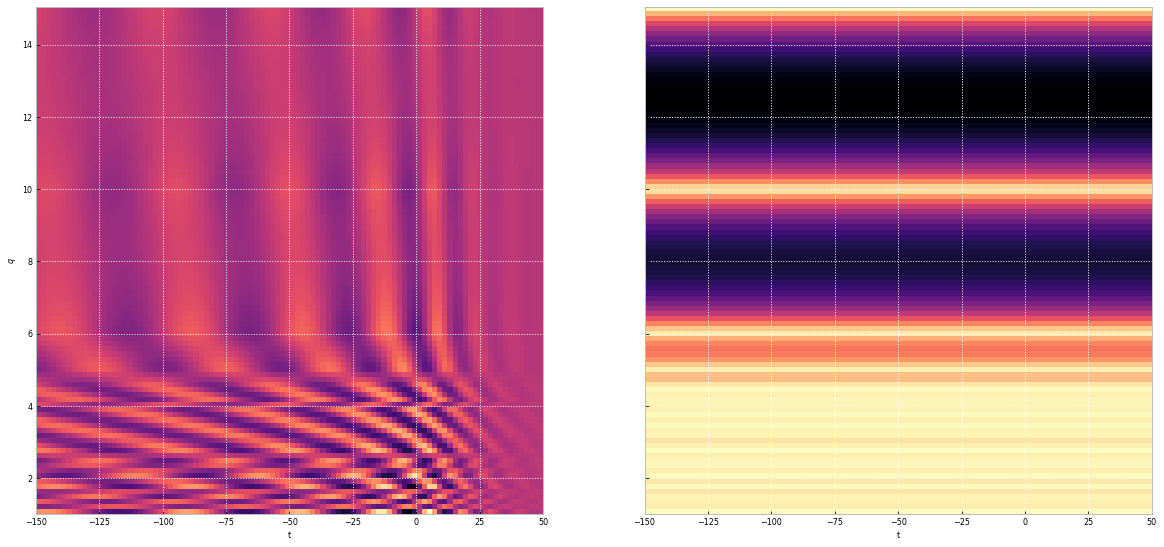

In [42]:
figure = plot_plane(gp, training, 0, 1, figsize=(20,20), intersept= [0,0,0,0,0,0,0,0,0.6])

Something distinctly odd is happening here; there are clearly meant to be waveforms at e.g. q=2.2 which are not available to the GP. Presumably these are some of the data which are missing from the catalogue we have?

## Test with the Hierarchical solver

Earlier tests with the hierarchical solver have indicated that it doesn't do a great job with our data.

In [19]:
gp_hodlr = george.GP(kernel, mean = 0.5, solver=george.HODLRSolver, seed=1, tol=0.0000001, min_size=100)
gp_hodlr.compute(x=training.targets, yerr=training.label_sigma)

It looks as if this is a problem with the size of the regularisation which `george` applies to the diagonal of the matrix (which is `0.1` by default), substantially reducing this seems to substantially improve matters, though there may be evidence that it has also introduced new numerical errors.

In [20]:
x = scipy.optimize.minimize(neglk, np.exp(gp_hodlr.get_parameter_vector()), method="L-BFGS-B", args=(gp_hodlr, training))

In [21]:
print x.x
print gp_hodlr.get_parameter_names()

[0.11111111 0.01111111 0.001      0.05555556 0.1        0.11111111
 0.02      ]
('kernel:k1:k1:log_constant', 'kernel:k1:k2:k1:k1:log_constant', 'kernel:k1:k2:k1:k2:metric:log_M_0_0', 'kernel:k1:k2:k2:k1:log_constant', 'kernel:k1:k2:k2:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:metric:log_M_0_0')


Additionally, the hierarchical solver seems to be much more sensitive to the values of the hyperparameters, and we don't seem to be able to get by with rough values and still get something sensible out at the end.

In [22]:
gp_hodlr.set_parameter_vector(np.log(x['x']))

In [23]:
gp_hodlr.compute(x=training.targets, yerr=training.label_sigma)

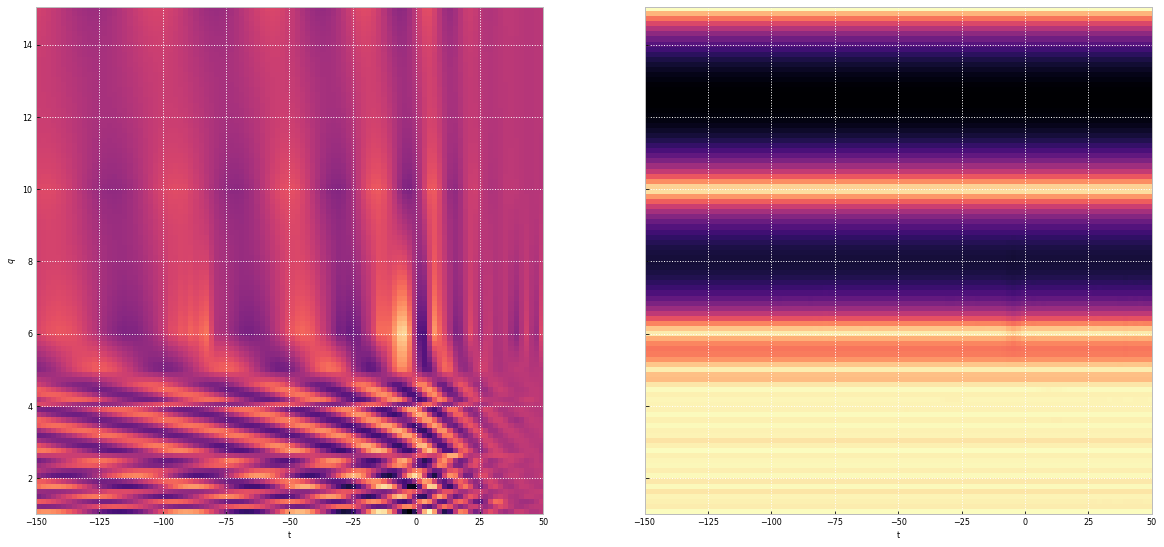

In [43]:
figure = plot_plane(gp_hodlr, training, 0, 1, figsize=(20,20))

This looks plausibly similar to the output of the standard Cholesky-solved version, and it does run a bit faster. Around q=4.2 there seems to be a bad numerical problem however.

In [25]:
gp_hodlr = george.GP(kernel, mean = 0.5, solver=george.HODLRSolver, seed=1, tol=0.00000001, min_size=100)
gp_hodlr.compute(x=training.targets, yerr=training.label_sigma)

The solution to this seems to be in reducing the `tol` quantity still further.

In [26]:
gp_hodlr.set_parameter_vector(np.log(x['x']))
gp_hodlr.compute(x=training.targets, yerr=training.label_sigma)

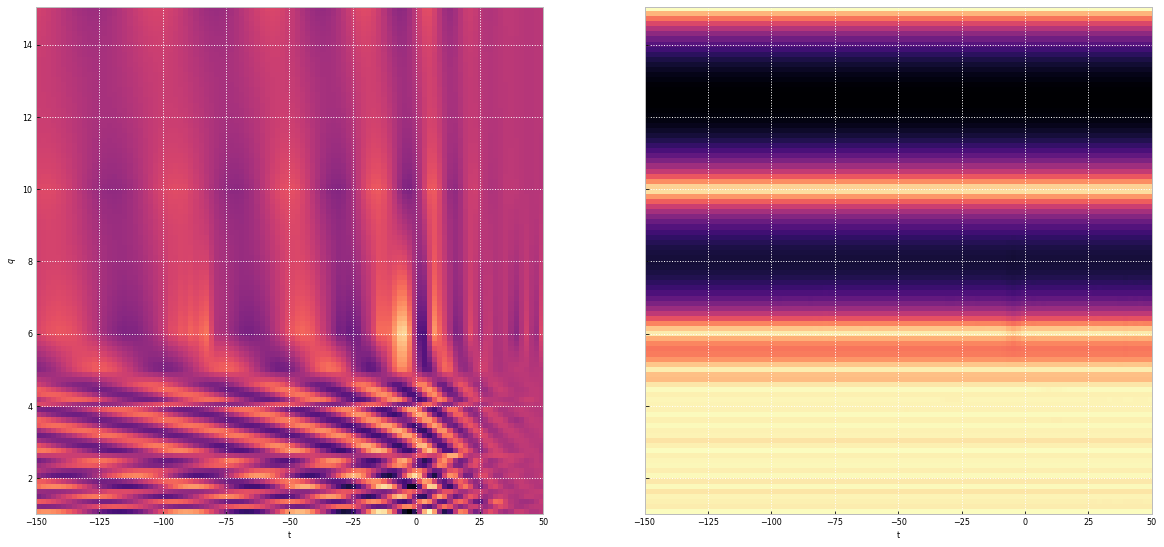

In [44]:
figure = plot_plane(gp_hodlr, training, 0, 1, figsize=(20,20))

This looks plausibly similar to the output of the standard Cholesky-solved version, and it does run a bit faster. Around q=4.2 there seems to be a bad numerical problem however.

# Single-spinning, all mass ratios

Waveforms are chosen to have a variety of mass-ratios ($q$-values), and may have a spin component on the $y$-axis of the second component. This expands our training set from 49 waveforms to 53. As it happens, the only waveforms with only the second component spinning have only spin in the $z$-axis for that component.

In [28]:
query = (
          (t["$a_{1x}$"]==0) 
         & (t["$a_{1y}$"]==0) 
         & (t["$a_{1z}$"]==0)                              
         & (t["$a_{2x}$"]==0)
         & (t["$a_{2y}$"]==0)
         #& (t["$a_{2z}$"]==0) 
        )

In [29]:
t[query]

Index,Name,tag,$q$,$a_{1x}$,$a_{1y}$,$a_{1z}$,$a_{2x}$,$a_{2y}$,$a_{2z}$,$L_x$,$L_y$,$L_z$,mf,af,mW
int64,str6,str44,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
55,GT0370,D10_a0.0_q1.15_m103_Qs,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9565,0.952,0.6836,0.05663
56,GT0371,D10_a0.0_q1.30_m103_Qs,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.945,0.9531,0.6768,0.0566
57,GT0372,D10_a0.0_q1.45_m103_Qs,1.45,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9292,0.9546,0.6675,0.05655
58,GT0374,D10_a0.0_q1.60_m103_Qs,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9107,0.9563,0.6565,0.0565
59,GT0376,D10_a0.0_q1.90_m103_Qs,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.87,0.96,0.6318,0.05639
60,GT0378,D10_a0.0_q2.05_m103_Qs,2.05,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.849,0.9618,0.619,0.05632
61,GT0379,D10_a0.0_q2.20_m103_Qs,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.828,0.9635,0.606,0.05626
62,GT0380,D10_a0.0_q2.35_m103_Qs,2.35,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.8073,0.9651,0.5932,0.0562
100,GT0446,D11_q2.00_a0.0_m200,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.8822,0.9612,0.6233,0.049


In [30]:
training_x, training_y = get_dataset(t, query = query)
training_spineq = heron.data.Data(targets=training_x.T, labels=np.array(training_y),
                           label_sigma = 0,
                          target_names = columns, label_names = ["h+"] )

[0.125  0.0125 0.001  0.0625 0.1    0.125  0.02  ]
('kernel:k1:k1:log_constant', 'kernel:k1:k2:k1:k1:log_constant', 'kernel:k1:k2:k1:k2:metric:log_M_0_0', 'kernel:k1:k2:k2:k1:log_constant', 'kernel:k1:k2:k2:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:metric:log_M_0_0')

In [31]:
k1 = kernels.Matern52Kernel(0.001, ndim=len(training_x.T[0]), axes=0)
k2 = kernels.Matern52Kernel(0.1, ndim=len(training_x.T[0]), axes=0)
k3 = kernels.ExpKernel((.02), ndim=len(training_x.T[0]), axes=(1))
k4 = kernels.ExpKernel((.02), ndim=len(training_x.T[0]), axes=(7))
kernel =  0.015625 * ( 0.0015625 * k1 + 0.0078125 * k2) * (0.015625 * k3) * (0.125*k4)
gp_spineq = george.GP(kernel, mean = 0.5)
gp_spineq.compute(x=training_spineq.targets, yerr=training_spineq.label_sigma)

In [32]:
x = scipy.optimize.minimize(neglk, np.exp(gp_spineq.get_parameter_vector()), 
                            method="L-BFGS-B", args=(gp_spineq,training_spineq))

In [33]:
print x.x
print gp_spineq.get_parameter_names()

[0.00173611 0.00017361 0.001      0.00086806 0.1        0.00173611
 0.02       0.01388889 0.02      ]
('kernel:k1:k1:k1:log_constant', 'kernel:k1:k1:k2:k1:k1:log_constant', 'kernel:k1:k1:k2:k1:k2:metric:log_M_0_0', 'kernel:k1:k1:k2:k2:k1:log_constant', 'kernel:k1:k1:k2:k2:k2:metric:log_M_0_0', 'kernel:k1:k2:k1:log_constant', 'kernel:k1:k2:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:metric:log_M_0_0')


In [34]:
gp_spineq.set_parameter_vector(np.log(x['x']))
gp_spineq.compute(x=training_spineq.targets, yerr=training_spineq.label_sigma)

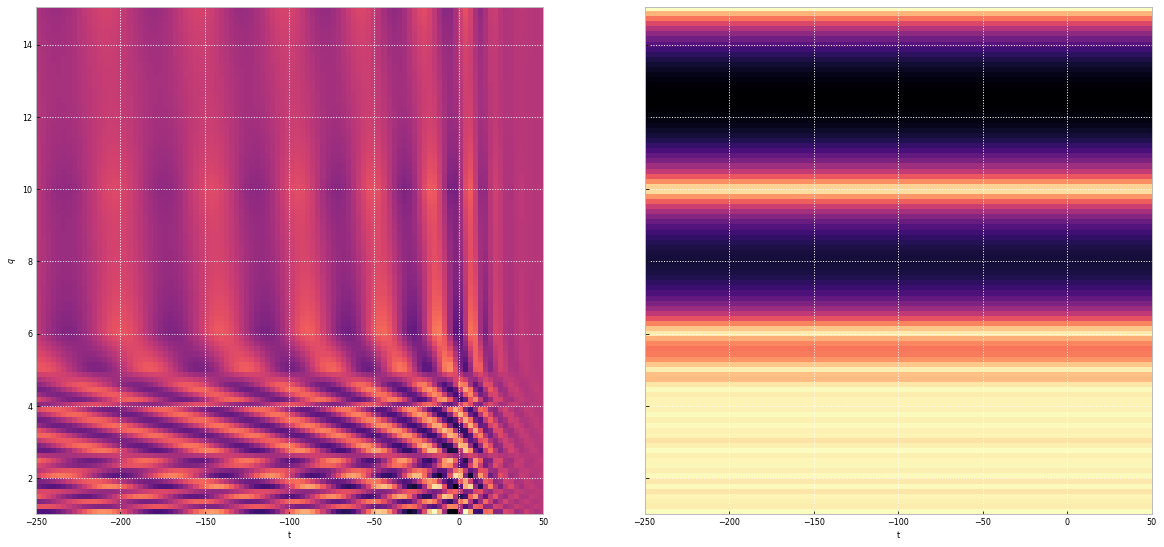

In [45]:
plot_plane(gp_spineq, training_spineq, i=0, j=1, figsize=(20,20));

Pleasingly this looks very similar to the results for non-spinning waveforms when the plane is produced in the non-spinning case.

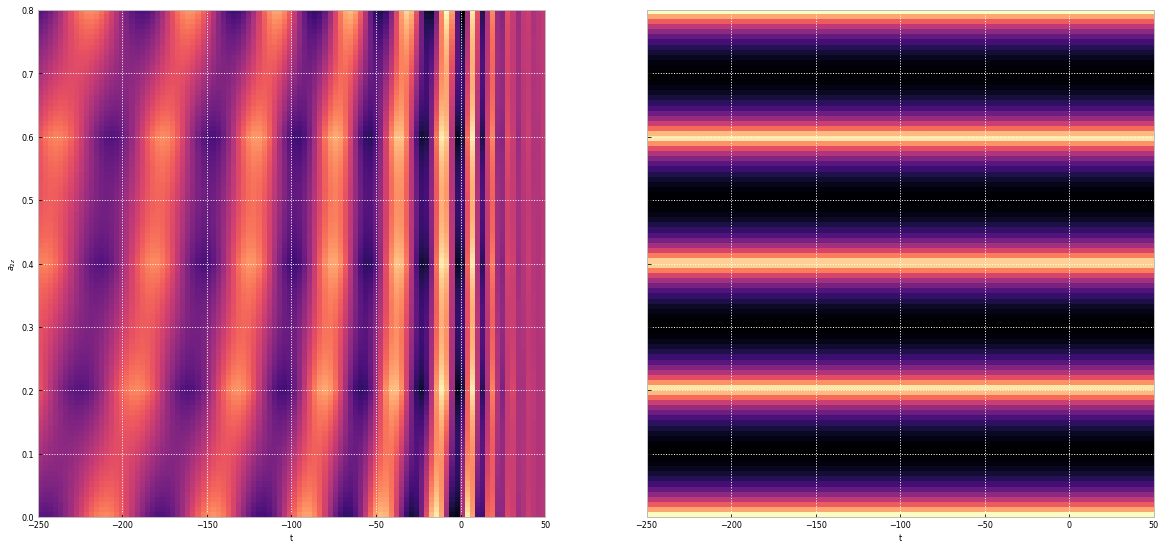

In [46]:
plot_plane(gp_spineq, training_spineq, i=0, j=7, figsize=(20,20));

The plot of the $y$-axis spin versus time also looks as though it produces sensible waveforms across the parameter space, albeit with high uncertainty.

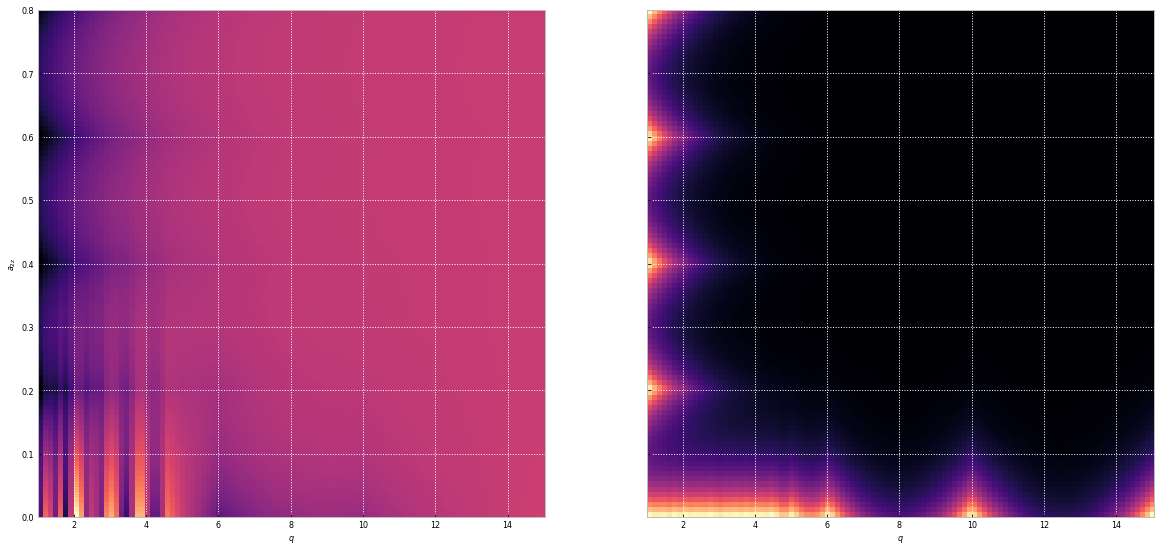

In [47]:
plot_plane(gp_spineq, training_spineq, i=1, j=7, figsize=(20,20));

The plot of the spin versus the mass ratio lays bare the extreme sparsity of the catalogue, with sampling only along the axes.

## Checking with the HODLR method

Again, it would be sensible to check that the hierarchical solver can also produce sensible results before we charge ahead with more complex models.

In [39]:
gp_spineq_hodlr = george.GP(kernel, mean = 0.5, solver=george.HODLRSolver, seed=1, tol=0.000000001, min_size=1000)
gp_spineq_hodlr.compute(x=training_spineq.targets, yerr=training_spineq.label_sigma)

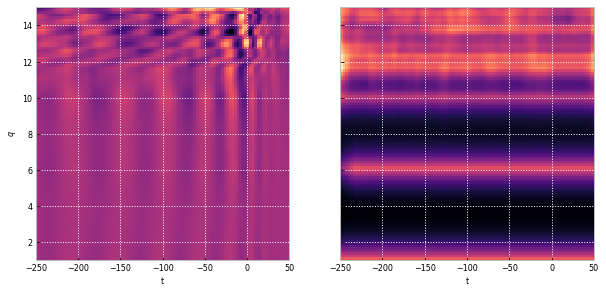

In [40]:
plot_plane(gp_spineq_hodlr, training_spineq, i=0, j=1, figsize=(10,10));

# Arbitrary primary spinning all mass-ratios

In this model we relax the constraint on the primary mass to be spin-free, and form a model with ~120 waveforms across the range of mass-ratios, and with an arbitrarily spinning primary component, but spin-free secondary.

In [50]:
query = (
         (t["$a_{2x}$"]==0) 
         & (t["$a_{2y}$"]==0) 
         & (t["$a_{2z}$"]==0)                              
        )

In [51]:
t[query].show_in_notebook()

idx,Index,Name,tag,$q$,$a_{1x}$,$a_{1y}$,$a_{1z}$,$a_{2x}$,$a_{2y}$,$a_{2z}$,$L_x$,$L_y$,$L_z$,mf,af,mW
0,55,GT0370,D10_a0.0_q1.15_m103_Qs,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9565,0.952,0.6836,0.05663
1,56,GT0371,D10_a0.0_q1.30_m103_Qs,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.945,0.9531,0.6768,0.0566
2,57,GT0372,D10_a0.0_q1.45_m103_Qs,1.45,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9292,0.9546,0.6675,0.05655
3,58,GT0374,D10_a0.0_q1.60_m103_Qs,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9107,0.9563,0.6565,0.0565
4,59,GT0376,D10_a0.0_q1.90_m103_Qs,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.87,0.96,0.6318,0.05639
5,60,GT0378,D10_a0.0_q2.05_m103_Qs,2.05,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.849,0.9618,0.619,0.05632
6,61,GT0379,D10_a0.0_q2.20_m103_Qs,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.828,0.9635,0.606,0.05626
7,62,GT0380,D10_a0.0_q2.35_m103_Qs,2.35,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.8073,0.9651,0.5932,0.0562
8,100,GT0446,D11_q2.00_a0.0_m200,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.8822,0.9612,0.6233,0.049
9,101,GT0448,D11_q1.00_a0.0_m240,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9911,0.9516,0.6862,0.04914


In [54]:
training_x, training_y = get_dataset(t, query = query, waveforms = 120, inspiral=50)
training_spinpar = heron.data.Data(targets=training_x.T, labels=np.array(training_y),
                           label_sigma = 0,
                          target_names = columns, label_names = ["h+"] )

[0.015625  0.0015625 0.001     0.0078125 0.1       0.015625  0.02
 0.125     0.02     ]
('kernel:k1:k1:k1:log_constant', 'kernel:k1:k1:k2:k1:k1:log_constant', 'kernel:k1:k1:k2:k1:k2:metric:log_M_0_0', 'kernel:k1:k1:k2:k2:k1:log_constant', 'kernel:k1:k1:k2:k2:k2:metric:log_M_0_0', 'kernel:k1:k2:k1:log_constant', 'kernel:k1:k2:k2:metric:log_M_0_0', 'kernel:k2:k1:log_constant', 'kernel:k2:k2:metric:log_M_0_0')

In [55]:
k1 = kernels.Matern52Kernel(0.001, ndim=len(training_x.T[0]), axes=0)
k2 = kernels.Matern52Kernel(0.100, ndim=len(training_x.T[0]), axes=0)
k3 = kernels.ExpKernel((.02), ndim=len(training_x.T[0]), axes=(1))
k4 = kernels.ExpKernel((0.02, 0.02, 0.02), ndim=len(training_x.T[0]), axes=(2,3,4))
k5 = kernels.ExpKernel((0.02, 0.02, 0.02), ndim=len(training_x.T[0]), axes=(5,6,7))
kernel =  0.015625 * ( 0.0015625 * k1 + 0.0078125 * k2) * (0.015625* k3) * (0.125*k4) #* (1*k5)
gp_spinpar = george.GP(kernel, mean = 0.5,) 
gp_spinpar.compute(x=training_spinpar.targets, yerr=training_spinpar.label_sigma)



In [ ]:
#x = scipy.optimize.minimize(neglk, np.exp(gp_spinpar.get_parameter_vector()), method="L-BFGS-B", args=(gp_spinpar, training_spinpar))
#gp_spinpar.set_parameter_vector(np.log(x['x']))
#gp_spinpar.compute(x=training_spinpar.targets, yerr=training_spinpar.label_sigma)

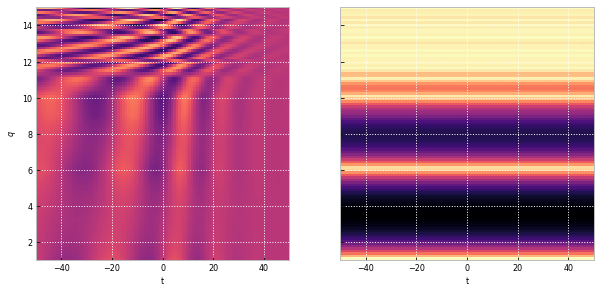

In [57]:
plot_plane(gp_spinpar, training_spinpar, i=0, j=1, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,0,0]);

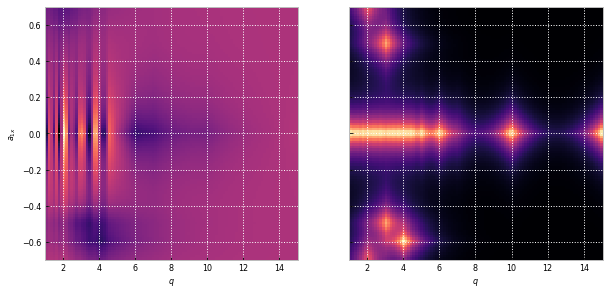

In [60]:
plot_plane(gp_spinpar, training_spinpar, i=1, j=2, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,-0.0,0]);

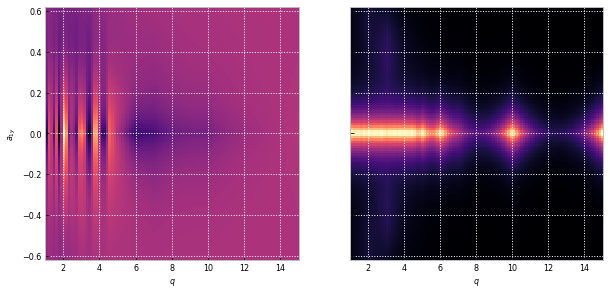

In [61]:
plot_plane(gp_spinpar, training_spinpar, i=1, j=3, figsize=(10,10),
           intersept=[0,1,0,0,0.0,0,0,-0.0,0]);

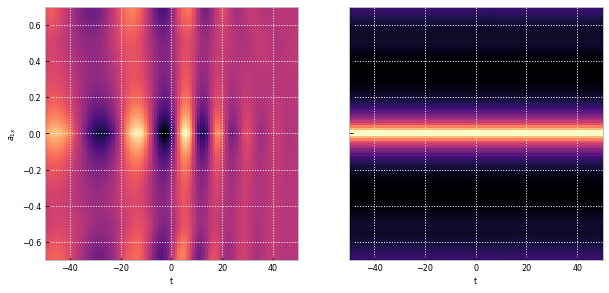

In [62]:
plot_plane(gp_spinpar, training_spinpar, i=0, j=2, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,-0.0,0]);

In [50]:
gp_spinpar_hodlr = george.GP(kernel, mean = 0.5, solver=george.HODLRSolver, seed=1, tol=0.00000001, min_size=1000)
gp_spinpar_hodlr.compute(x=training_spinpar.targets, yerr=training_spinpar.label_sigma)

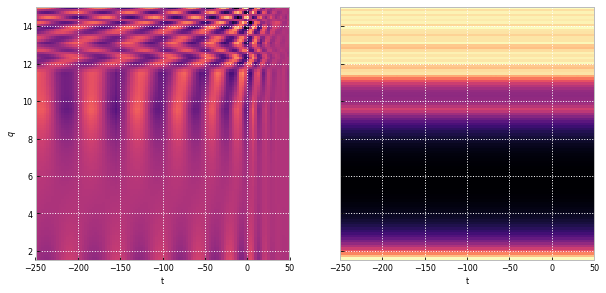

In [51]:
plot_plane(gp_spinpar_hodlr, training_spinpar, i=0, j=1, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,0,]);

# Both Spinning

In this model we allow both components to spin, but we restrict the spin on the second component to only be in the $z$-axis.

In [63]:
query = (
         (t["$a_{2x}$"]==0) 
         & (t["$a_{2y}$"]==0) 
         # (t["$a_{2z}$"]==0)                              
        )

In [64]:
t[query].show_in_notebook()

idx,Index,Name,tag,$q$,$a_{1x}$,$a_{1y}$,$a_{1z}$,$a_{2x}$,$a_{2y}$,$a_{2z}$,$L_x$,$L_y$,$L_z$,mf,af,mW
0,51,GT0355,D11_a0.2_q1.00_m103_As,1.0,0.0,0.0,0.2,0.0,0.0,-0.2,0,-0.0,0.9911,0.9515,0.6861,0.04918
1,52,GT0356,D11_a0.4_q1.00_m103_As,1.0,0.0,0.0,0.3999,0.0,0.0,-0.4001,0,-0.0,0.9911,0.9514,0.6857,0.0492
2,53,GT0357,D11_a0.6_q1.00_m103_As,1.0,0.0,0.0,0.5999,0.0,0.0,-0.6001,0,-0.0,0.9911,0.9512,0.6849,0.04919
3,54,GT0358,D11_a0.8_q1.00_m103_As,1.0,0.0,0.0,0.7999,0.0,0.0,-0.8001,0,-0.0,0.9911,0.9509,0.6839,0.04922
4,55,GT0370,D10_a0.0_q1.15_m103_Qs,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9565,0.952,0.6836,0.05663
5,56,GT0371,D10_a0.0_q1.30_m103_Qs,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.945,0.9531,0.6768,0.0566
6,57,GT0372,D10_a0.0_q1.45_m103_Qs,1.45,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9292,0.9546,0.6675,0.05655
7,58,GT0374,D10_a0.0_q1.60_m103_Qs,1.6,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.9107,0.9563,0.6565,0.0565
8,59,GT0376,D10_a0.0_q1.90_m103_Qs,1.9,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.87,0.96,0.6318,0.05639
9,60,GT0378,D10_a0.0_q2.05_m103_Qs,2.05,0.0,0.0,0.0,0.0,0.0,0.0,0,-0.0,0.849,0.9618,0.619,0.05632


In [65]:
training_x, training_y = get_dataset(t, query = query, waveforms = 196, inspiral=50, skip=10)
training_spin2 = heron.data.Data(targets=training_x.T, labels=np.array(training_y),
                           label_sigma = 0,
                          target_names = columns, label_names = ["h+"] )

In [66]:
print len(training_y)

13831


In [ ]:
k1 = kernels.Matern52Kernel(0.001, ndim=len(training_x.T[0]), axes=0)
k2 = kernels.Matern52Kernel(0.1, ndim=len(training_x.T[0]), axes=0)
k3 = kernels.ExpKernel((.02), ndim=len(training_x.T[0]), axes=(1))
k4 = kernels.ExpKernel((0.02, 0.02, 0.02), ndim=len(training_x.T[0]), axes=(2,3,4))
k5 = kernels.ExpKernel((0.02), ndim=len(training_x.T[0]), axes=(5))
kernel =  1 * ( 1 * k1 + 1 * k2) * (1 * k3) * (1*k4) * (1*k5)
gp_spin2 = george.GP(kernel, mean = 0.5, solver=george.HODLRSolver, seed=1, tol=0.00000001, min_size=100) 
gp_spin2.compute(x=training_spin2.targets, yerr=training_spin2.label_sigma)

In [105]:
x = scipy.optimize.minimize(neglk, np.exp(gp_spin2.get_parameter_vector()), jac=True, method="L-BFGS-B", args=(gp_spin2, training_spin2))

MemoryError: 

In [97]:
print x['x']
gp_spin2.set_parameter_vector(np.log(x['x']))
gp_spin2.compute(x=training_spin2.targets, yerr=training_spin2.label_sigma)

[0.00195312 0.00019531 0.001      0.00097656 0.1        0.00195312
 0.02       0.015625   0.02       0.02       0.02       0.015625
 0.02      ]


In [ ]:
plot_plane(gp_spin2, training_spin2, i=0, j=1, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,0,0]);

# The Monster

In this model, there are no restictions on any parameter; the entire catalogue is modelled.

In [21]:
query = (
         (t["$a_{2x}$"]>=-100) 
         #& (t["$a_{2y}$"]==0) 
         # (t["$a_{2z}$"]==0)                              
        )

In [22]:
t.show_in_notebook()

idx,Index,Name,tag,$q$,$a_{1x}$,$a_{1y}$,$a_{1z}$,$a_{2x}$,$a_{2y}$,$a_{2z}$,$L_x$,$L_y$,$L_z$,mf,af,mW
0,1,GT0001,fr_b3.1_a0.4_oth.000_M77,1.0,0.0,0.0,0.3999,-0.4001,0.0,0.0,0,0.0,0.8261,nan,nan,0.09957
1,2,GT0002,fr_b3.1_a0.4_oth.045_M77,1.0,0.2828,0.0,0.2828,-0.4001,0.0,0.0,0,0.0,0.8323,nan,nan,0.1001
2,3,GT0003,fr_b3.1_a0.4_oth.090_M77,1.0,0.4,0.0,2.449e-17,-0.4,0.0,0.0,0,0.0,0.8467,nan,nan,0.1012
3,4,GT0004,fr_b3.1_a0.4_oth.135_M77,1.0,-0.3999,0.0,0.0,0.2829,0.0,-0.2829,0,0.0,-0.8608,nan,nan,0.1025
4,5,GT0005,fr_b3.1_a0.4_oth.180_M77,1.0,-0.3999,0.0,0.0,4.9e-17,0.0,-0.4001,0,0.0,-0.8664,nan,nan,0.103
5,6,GT0006,fr_b3.1_a0.4_oth.225_M77,1.0,-0.3999,0.0,0.0,-0.2829,0.0,-0.2829,0,0.0,-0.8602,nan,nan,0.1022
6,7,GT0007,fr_b3.1_a0.4_oth.270_M77,1.0,-0.4,0.0,-7.348e-17,-0.4,0.0,0.0,0,0.0,0.8458,nan,nan,0.1008
7,8,GT0008,fr_b3.1_a0.4_oth.315_M77,1.0,-0.2828,0.0,0.2828,-0.4001,0.0,0.0,0,0.0,0.8316,nan,nan,0.09983
8,9,GT0009,fr_b3.1_a0.2_oth.000_M77,1.0,0.0,0.0,0.2,-0.2,0.0,0.0,0,0.0,0.8362,nan,nan,0.1004
9,10,GT0010,fr_b3.1_a0.2_oth.045_M77,1.0,0.1414,0.0,0.1414,-0.2,0.0,0.0,0,0.0,0.8392,nan,nan,0.1006


In [25]:
training_x, training_y = get_dataset(t, query = query, waveforms = 452, inspiral=25, ringdown=25, skip=15)
training_spin_monster = heron.data.Data(targets=training_x.T, labels=np.array(training_y),
                           label_sigma = 0,
                          target_names = columns, label_names = ["h+"] )

In [41]:
k1 = kernels.Matern52Kernel(0.001, ndim=len(training_x.T[0]), axes=0)
k2 = kernels.Matern52Kernel(0.1, ndim=len(training_x.T[0]), axes=0)
k3 = kernels.ExpKernel((.02), ndim=len(training_x.T[0]), axes=(1))
k4 = kernels.ExpKernel((0.125, 0.125, 0.125), ndim=len(training_x.T[0]), axes=(2,3,4))
k5 = kernels.ExpKernel((0.125, 0.125, 0.125), ndim=len(training_x.T[0]), axes=(5,6,7))
kernel =  1.0 * ( 0.1 * k1 + 0.5 * k2) * (1.0* k3) * (1*k4) * (1*k5)
gp_spin_monster = george.GP(kernel, mean = 0.5, solver=george.HODLRSolver, seed=1, tol=0.000000001, min_size=100) 
gp_spin_monster.compute(x=training_spin_monster.targets, yerr=training_spin_monster.label_sigma)

In [34]:
#x = scipy.optimize.minimize(neglk, np.exp(gp_spin_monster.get_parameter_vector()), method="L-BFGS-B", args=(gp_spin_monster, training_spin_monster))

In [35]:
#gp_spin_monster.set_parameter_vector(np.log(x['x']))
#gp_spin_monster.compute(x=training_spinpar.targets, yerr=training_spinpar.label_sigma)

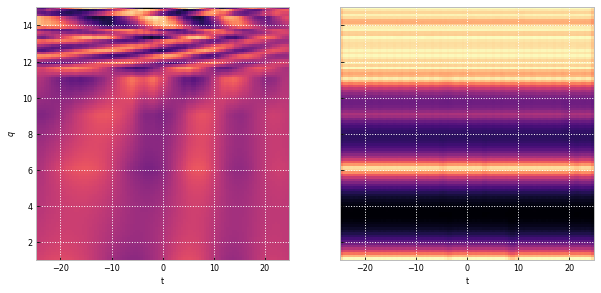

In [40]:
plot_plane(gp_spin_monster, training_spin_monster, i=0, j=1, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,0,]);

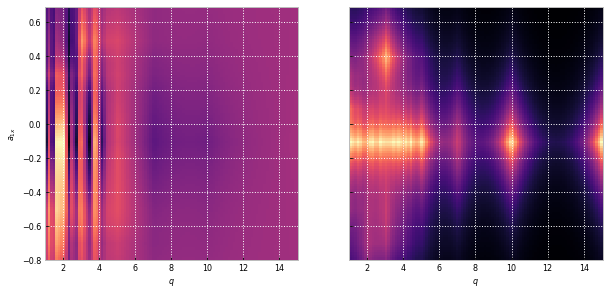

In [37]:
plot_plane(gp_spin_monster, training_spin_monster, i=1, j=2, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,0,]);

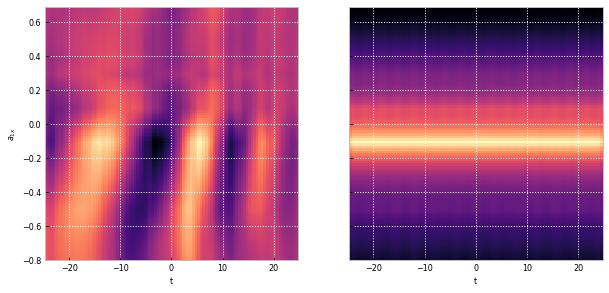

In [38]:
plot_plane(gp_spin_monster, training_spin_monster, i=0, j=2, figsize=(10,10),
           intersept=[0,0,0,0,0.0,0,0,0,]);

# Trying more complex kernels

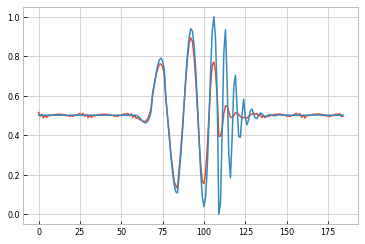

In [168]:
k1 = kernels.ExpSine2Kernel(4, np.log(.01), ndim=len(sep), axes=0)
k2 = kernels.Matern52Kernel(0.001, ndim=len(sep), axes=0)
kernel = k1  + k2
gp = george.GP(kernel,
                    mean = np.mean(training.labels),
                    fit_mean=False,
                    fit_white_noise=False
)
gp.compute(x=training.targets[:,:,0], yerr=training.label_sigma)
a = gp.predict(training.labels,training.targets[:,:,0], return_var=True)
plt.plot(a[0])
plt.plot(training.labels)

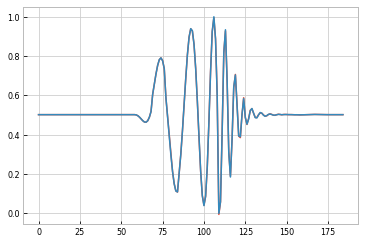

In [180]:
k1 = kernels.ExpSquaredKernel(0.0008, ndim=len(sep), axes=0)
#k2 = kernels.Matern52Kernel(0.001, ndim=len(sep), axes=0)
kernel = k1  #+ k2
gp = george.GP(kernel,
                    mean = np.mean(training.labels),
                    fit_mean=False,
                    fit_white_noise=False
)
gp.compute(x=training.targets[:,:,0], yerr=0*training.label_sigma)
a = gp.predict(training.labels,training.targets[:,:,0], return_var=True)
plt.plot(a[0])
plt.plot(training.labels)